# Combine all the data into once dataset

Once you've run the following notebooks,
- 01_stt_pecha_tools.ipynb
- 02_prodigy.ipynb
- 03_mv_saymore.ipynb

You get the following tsv files
- 01_stt_pecha_tools.tsv
- 02_prodigy.tsv
- 03_mv_saymore.tsv

Concatenate the tsv files and clean the data

In [1]:
stt_pecha_tools = "01_stt_pecha_tools.csv"
prodigy =         "02_prodigy_finalised.csv"

In [2]:
import pandas as pd
pecha_tools_df = pd.read_csv(stt_pecha_tools)
prodigy_df = pd.read_csv(prodigy)

In [3]:
prodigy_df.head()

,id,transcript,len,dept
0,STT_TT00001_00233.450-00233.950,དེ་འདྲ་ཡིན་དུས་,15,STT_TT
1,STT_TT00001_00328.100-00329.300,ཨེ། དཔལ་མགོན་འཕགས་པ་ཀླུ་སྒྲུབ་ཀི་,33,STT_TT
2,STT_TT00001_00083.000-00083.750,ཉིན་རེ་ཉིན་རེའི།,16,STT_TT
3,STT_TT00001_00240.650-00241.550,འདིའི་གོང་ལ།,12,STT_TT
4,STT_TT00001_00102.350-00103.700,ཨེ་ནས་ཅིག་སེམས་འཁྲུགས་བསྡད་ཡ།,29,STT_TT


In [4]:
prodigy_df = prodigy_df.rename(columns={'id': 'file_name', 'transcript':'uni'})
prodigy_df.head()

,file_name,uni,len,dept
0,STT_TT00001_00233.450-00233.950,དེ་འདྲ་ཡིན་དུས་,15,STT_TT
1,STT_TT00001_00328.100-00329.300,ཨེ། དཔལ་མགོན་འཕགས་པ་ཀླུ་སྒྲུབ་ཀི་,33,STT_TT
2,STT_TT00001_00083.000-00083.750,ཉིན་རེ་ཉིན་རེའི།,16,STT_TT
3,STT_TT00001_00240.650-00241.550,འདིའི་གོང་ལ།,12,STT_TT
4,STT_TT00001_00102.350-00103.700,ཨེ་ནས་ཅིག་སེམས་འཁྲུགས་བསྡད་ཡ།,29,STT_TT


In [5]:
df = pd.concat([pecha_tools_df, prodigy_df], ignore_index=True)

In [6]:
bad_apples = pd.read_csv('04_bad_apples.csv')

In [7]:
df = df[~df['file_name'].isin(bad_apples['file_name'])]

Drop duplicates, duplicates were introduced from prodigy annotation tool. One of the reason we had to move away from it.

In [8]:
df.drop_duplicates(subset='file_name', keep="first", inplace=True)

### clean the combined tsv

Remove unwanted characters and remove transcriptions with english characters

In [9]:
import re
def clean_transcription(text):
    text = text.replace('\n', ' ')
    text = text.replace('\t', ' ')
    text = text.strip()

    text = re.sub("༌", "་",text) # there are two type of 'tsak' let's normalize 0xf0b to 0xf0c
    text = re.sub("༎", "།",text) # normalize double 'shae' 0xf0e to 0xf0d

    text = re.sub("ཽ", "ོ",text) # normalize
    text = re.sub("ཻ", "ེ",text) # normalize

    text = re.sub(r"་+", "་", text)
    text = re.sub(r"།+", "།", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"\s+།", "།", text)

    text = re.sub(r"ཧཧཧ+", "ཧཧཧ", text)
    text = re.sub(r'འེ་འེ་(འེ་)+', r'འེ་འེ་འེ་', text)
    text = re.sub(r'ཧ་ཧ་(ཧ་)+', r'ཧ་ཧ་ཧ་', text)

    chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"\“\%\‘\”\�\/\{\}\(\)\༽\》\༼\《\༅\༄\༈\༑\༠\\'\|\·\×\༆\༌\༎\༔\༷\༸\༾\ཿ\྄\྅\྆\྇\ྋ\࿒\ᨵ\​\’\„\╗\╚]'
    
    text = re.sub(chars_to_ignore_regex, '', text)+" "
    return text

def check_if_regex(text):
    text = str(text)
    regex = re.compile(r'[0-9a-zA-Z]+')
    match = re.search(regex, text)
    
    return bool(match)
    
print(check_if_regex('ཧཧ'))
print(check_if_regex('some text'))

False
True


In [10]:
df = df[df['uni'].str.len() > 0]

In [11]:
df = df[~df['uni'].apply(check_if_regex)]

In [12]:
df['uni'] = df['uni'].map(clean_transcription)

In [13]:
def extract_all_chars(text):
    all_text = " ".join(text)
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

In [15]:
! pip install datasets

  Using cached datasets-2.18.0-py3-none-any.whl (510 kB)
  Using cached fsspec-2024.2.0-py3-none-any.whl (170 kB)
  Using cached pyarrow-15.0.2-cp310-cp310-manylinux_2_28_x86_64.whl (38.3 MB)
  Using cached multiprocess-0.70.16-py310-none-any.whl (134 kB)
  Using cached xxhash-3.4.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (194 kB)
  Using cached filelock-3.13.3-py3-none-any.whl (11 kB)
  Using cached dill-0.3.8-py3-none-any.whl (116 kB)
  Using cached huggingface_hub-0.22.2-py3-none-any.whl (388 kB)
  Using cached pyarrow_hotfix-0.6-py3-none-any.whl (7.9 kB)
  Using cached aiohttp-3.9.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
  Using cached multidict-6.0.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (124 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
  Using cached async_timeout-4.0.3-py3-none-any.whl (5.7 kB)
  Using cached yarl-1.9.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (301 kB)
  Using 

In [16]:
from datasets import Dataset
common_voice_train = Dataset.from_pandas(df)

In [17]:
def extract_all_chars(batch):
    all_text = " ".join(batch["uni"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

In [18]:
vocab_train = common_voice_train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_train.column_names)

Map:   0%|          | 0/705906 [00:00<?, ? examples/s]

In [19]:
vocab_list = list(set(vocab_train["vocab"][0]))

In [20]:
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
vocab_dict

{'ྜ': 0,
 'ི': 1,
 'ྰ': 2,
 'ཤ': 3,
 'ྴ': 4,
 '༥': 5,
 'ྂ': 6,
 'ཞ': 7,
 'ྫ': 8,
 'ྒ': 9,
 'ལ': 10,
 'འ': 11,
 '༡': 12,
 'ༀ': 13,
 'ཪ': 14,
 'ླ': 15,
 'ཛ': 16,
 'ཙ': 17,
 'ྡྷ': 18,
 'ཕ': 19,
 '།': 20,
 'ཨ': 21,
 'ཊ': 22,
 'ཱྀ': 23,
 'ྼ': 24,
 'ྞ': 25,
 'ཅ': 26,
 '༧': 27,
 'ུ': 28,
 'ཱུ': 29,
 'ཥ': 30,
 'པ': 31,
 'མ': 32,
 'བྷ': 33,
 'ཆ': 34,
 'ྪ': 35,
 'ད': 36,
 'ཉ': 37,
 'ཚ': 38,
 'ོ': 39,
 'ཟ': 40,
 'ྐ': 41,
 '༩': 42,
 'ྟ': 43,
 'ཇ': 44,
 '༤': 45,
 'ཀྵ': 46,
 'ྖ': 47,
 'ྚ': 48,
 'ར': 49,
 'ག': 50,
 'ྔ': 51,
 'ཎ': 52,
 '༨': 53,
 'ྑ': 54,
 'ཁ': 55,
 'བ': 56,
 'ཏ': 57,
 '༦': 58,
 'ས': 59,
 'ཝ': 60,
 'ྤ': 61,
 'ཋ': 62,
 'ྸ': 63,
 'ྀ': 64,
 'ྡ': 65,
 'ྠ': 66,
 'ཱ': 67,
 '༢': 68,
 'ཀ': 69,
 'ྥ': 70,
 'ྗ': 71,
 'ཧ': 72,
 'ྕ': 73,
 'དྷ': 74,
 'ན': 75,
 'ཾ': 76,
 '༣': 77,
 'ྩ': 78,
 'གྷ': 79,
 'ྣ': 80,
 'ྲ': 81,
 'ྵ': 82,
 '་': 83,
 'ྛ': 84,
 'ཷ': 85,
 'ེ': 86,
 'ྃ': 87,
 'ྨ': 88,
 'ཌྷ': 89,
 'ྱ': 90,
 'ྦ': 91,
 'ྙ': 92,
 'ང': 93,
 'ྦྷ': 94,
 ' ': 95,
 'ཡ': 96,
 'ྻ': 97,
 'ཱི': 98,
 'ྷ': 99,
 'ཐ': 100,

In [25]:
all = ''
for c in vocab_dict:
    all += c

In [39]:
sorted(all)
print("num of unique chars:", len(all))
x="".join([str(i) for i in sorted(all)])
print(x)

print()

x="ཨ".join([str(i) for i in sorted(all)])
print(x)

num of unique chars: 104
 ༀ་།༡༢༣༤༥༦༧༨༩ཀཁགགྷངཅཆཇཉཊཋཌཌྷཎཏཐདདྷནཔཕབབྷམཙཚཛཝཞཟའཡརལཤཥསཧཨཀྵཪཱཱཱིིུུཷེོཾཱྀྀྂྃྐྑྒྔྕྖྗྙྚྛྜྞྟྠྡྡྷྣྤྥྦྦྷྨྩྪྫྭྰྱྲླྴྵྶྷྸྻྼ

 ཨༀཨ་ཨ།ཨ༡ཨ༢ཨ༣ཨ༤ཨ༥ཨ༦ཨ༧ཨ༨ཨ༩ཨཀཨཁཨགཨགྷཨངཨཅཨཆཨཇཨཉཨཊཨཋཨཌཨཌྷཨཎཨཏཨཐཨདཨདྷཨནཨཔཨཕཨབཨབྷཨམཨཙཨཚཨཛཨཝཨཞཨཟཨའཨཡཨརཨལཨཤཨཥཨསཨཧཨཨཨཀྵཨཪཨཱཨིཨཱིཨུཨཱུཨཷཨེཨོཨཾཨྀཨཱྀཨྂཨྃཨྐཨྑཨྒཨྔཨྕཨྖཨྗཨྙཨྚཨྛཨྜཨྞཨྟཨྠཨྡཨྡྷཨྣཨྤཨྥཨྦཨྦྷཨྨཨྩཨྪཨྫཨྭཨྰཨྱཨྲཨླཨྴཨྵཨྶཨྷཨྸཨྻཨྼ


In [ ]:
! pip install pyewts

### Convert unicode tibetan characters into wylie format

In [55]:
import pyewts

converter = pyewts.pyewts()

df['wylie'] = df['uni'].apply(converter.toWylie)

In [56]:
df['char_len'] = df['uni'].str.len()

In [ ]:
! pip install matplotlib

<Axes: >

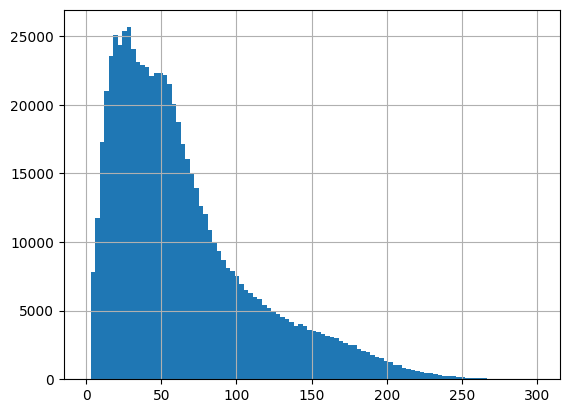

In [57]:
df['char_len'].hist(bins=100, range=(0, 300))

In [58]:
df['char_len'].describe()

count    705929.000000
mean         64.414722
std          47.495571
min           1.000000
25%          29.000000
50%          52.000000
75%          86.000000
max         393.000000
Name: char_len, dtype: float64

In [59]:
df.shape[0]

705929

In [60]:
upper_cutoff = 400
lower_cutoff = 5

In [61]:
df[df['char_len'] > upper_cutoff].shape[0], df[df['char_len'] < lower_cutoff].shape[0]

(0, 6008)

In [62]:
df[df['char_len'] > upper_cutoff][['uni', 'url', 'char_len']].sort_values(by='char_len').to_csv('04_longer_than_upper_cutoff.tsv', sep='\t', index=False)

In [63]:
df[df['char_len'] < lower_cutoff][['uni', 'url', 'char_len']].sort_values(by='char_len').to_csv('04_shorter_than_lower_cutoff.tsv', sep='\t', index=False)

In [64]:
df = df[(df['char_len'] < upper_cutoff) & (df['char_len'] > lower_cutoff)]

In [65]:
df.shape[0]

698056

### Get the audio time duration from the file name. 

There is to format for encoding the time span. We use the one with \_to\_ now. The difference came from the using a different library to do the Voice Activity Detection and splitting the audio for Tibetan Teachings. We have since started using pyannote-audio for all departments now.

In [66]:
def getTimeSpan(filename):

    filename = filename.replace(".wav", "")
    filename = filename.replace(".WAV", "")
    filename = filename.replace(".mp3", "")
    filename = filename.replace(".MP3", "")
    try:
        if "_to_" in filename:
            start, end = filename.split("_to_")
            start = start.split("_")[-1]
            end = end.split("_")[0]
            end = float(end)
            start = float(start)
            return abs(end - start)/1000
        else:
            start, end = filename.split("-")
            start = start.split("_")[-1]
            end = end.split("_")[0]
            end =   float(end)
            start = float(start)
            return abs(end - start)
    except Exception as err:
        print(f"filename is:'{filename}'. Could not parse to get time span.")
        return 0
    

getTimeSpan("STT_TT00031_03471.850-03477.44")

5.5900000000001455

In [67]:
df['audio_len'] = df['file_name'].apply(getTimeSpan)

In [68]:
df['audio_len'].describe()

count    698056.000000
mean          3.414205
std           2.616168
min           0.200000
25%           1.450000
50%           2.550000
75%           4.544000
max          13.650000
Name: audio_len, dtype: float64

<Axes: >

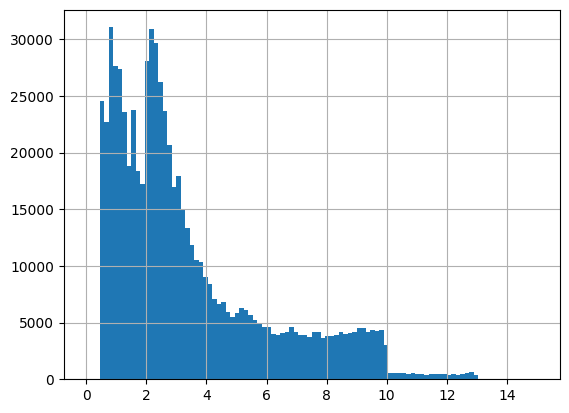

In [69]:
df['audio_len'].hist(bins=100, range=(0, 15))

In [73]:
df['url'] = 'https://d38pmlk0v88drf.cloudfront.net/wav16k/' + df['file_name'] + '.wav'

In [74]:
df['url'] = df['url'].map(lambda x : x.replace('#','%23'))

In [75]:
df = df[['file_name','uni', 'wylie', 'url', 'dept', 'grade', 'char_len',  'audio_len']]

In [76]:
df.head()

,file_name,uni,wylie,url,dept,grade,char_len,audio_len
0,STT_NS_M0310_0558_3487414_to_3495844,ཡར་ལངས་ལྦ་ཡེ་ག་རེ་བྱས་ཡོད། ཡི་གེ་སྦྱང། ཡི་གེ་བ...,yar langs lba ye ga re byas yod/_yi ge sbyang/...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_NS,3.0,149,8.430
1,STT_NS_M0310_0677_4317792_to_4319824,རྒྱལ་ཡོངས་ག་བ་ལ་ཁྱེད་རང་ང་ཨཱ་ཡེ།,rgyal yongs ga ba la khyed rang nga A ye/_,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_NS,3.0,33,2.032
2,STT_NS_M0310_0666_4270034_to_4272460,རྒྱ་གར་མི་དེ་ཚོ་ང་འཛིང་རྒྱོ་དེ་འདྲའི་དམིགས་བསལ...,rgya gar mi de tsho nga 'dzing rgyo de 'dra'i ...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_NS,3.0,62,2.426
3,STT_NS_M0310_0684_4361257_to_4363498,དངོས་གནས་སེམས་པ་བཟང་པོ་དང་དེ་འདྲའི་བརྩི་འགྲོ་ག...,dngos gnas sems pa bzang po dang de 'dra'i brt...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_NS,3.0,55,2.241
4,STT_NS_M0310_0659_4232255_to_4234484,རྒྱལ་ཁབ་གི་ཆེད་དུ་ཡང་མིན་ན་མི་རིགས་ཀི་ཆེད་དུ་རཱ།,rgyal khab gi ched du yang min na mi rigs ki c...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_NS,3.0,49,2.229


In [77]:
df.to_csv('04_combine_all.tsv', sep='\t', index=False)

In [80]:
df['uni'].str.contains('ཧཧཧ').value_counts()

uni
False    697983
True         73
Name: count, dtype: int64

In [2]:
import pandas as pd

df = pd.read_csv('04_combine_all.tsv', sep='\t')

In [2]:
df.head()

,file_name,uni,wylie,url,dept,grade,char_len,audio_len
0,STT_NS_M0310_0558_3487414_to_3495844,ཡར་ལངས་ལྦ་ཡེ་ག་རེ་བྱས་ཡོད། ཡི་གེ་སྦྱང། ཡི་གེ་བ...,yar langs lba ye ga re byas yod/_yi ge sbyang/...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_NS,3.0,149,8.430
1,STT_NS_M0310_0677_4317792_to_4319824,རྒྱལ་ཡོངས་ག་བ་ལ་ཁྱེད་རང་ང་ཨཱ་ཡེ།,rgyal yongs ga ba la khyed rang nga A ye/_,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_NS,3.0,33,2.032
2,STT_NS_M0310_0666_4270034_to_4272460,རྒྱ་གར་མི་དེ་ཚོ་ང་འཛིང་རྒྱོ་དེ་འདྲའི་དམིགས་བསལ...,rgya gar mi de tsho nga 'dzing rgyo de 'dra'i ...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_NS,3.0,62,2.426
3,STT_NS_M0310_0684_4361257_to_4363498,དངོས་གནས་སེམས་པ་བཟང་པོ་དང་དེ་འདྲའི་བརྩི་འགྲོ་ག...,dngos gnas sems pa bzang po dang de 'dra'i brt...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_NS,3.0,55,2.241
4,STT_NS_M0310_0659_4232255_to_4234484,རྒྱལ་ཁབ་གི་ཆེད་དུ་ཡང་མིན་ན་མི་རིགས་ཀི་ཆེད་དུ་རཱ།,rgyal khab gi ched du yang min na mi rigs ki c...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,STT_NS,3.0,49,2.229


In [79]:
df.groupby('dept')['audio_len'].sum()/60/60

dept
STT_AB    105.184844
STT_CS     96.809728
STT_MV      1.652947
STT_NS    169.568870
STT_PC     14.791548
STT_TT    274.021529
Name: audio_len, dtype: float64

In [78]:
df['audio_len'].sum()/60/60

662.0294658333335

In [11]:
# df.sort_values(by='audio_len', ascending=False, inplace=True)
df = df.sample(frac = 1)

In [12]:
df.iloc[0:100,[0, 1, 3, 5]].to_csv("04_random_100.tsv", index=False, sep='\t')
df.iloc[0:100,[0, 1, 3, 5]].head()

,file_name,uni,url,grade
418812,STT_CS-X2019_X2019-M_P-D_D-02##_02##-0_0-Y_Y-0...,སྦོས་ཧ་ཧ་ཧ། སྦོ།,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,NaN
181925,STT_TT00544_0298_2079537_to_2082321,རེད་ཡང་རེད་བ། དེ་ནས་གྲུབ་ཆེན་དྲིལ་བུ་པ་དང་དེ་ཚ...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,3.0
336274,STT_NS_M0246_0037_239701_to_247465,ཨ་ནས་རྨོ་མོ་མཉམ་དུ་སྐད་ཆ་བཤད་ཨེ་འདྲ་བྱས་ནས་ཡང་...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,3.0
391653,STT_TT00030_00194.700-00196.350,ཨ། ཡུལ་གཅིག་ལ།,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,NaN
684506,STT_TT00367_0008_50110_to_52278,དགེ་རྒན་དེས་གསུངས་བཞག་རྒྱོ་དེ། རེད་འདུག་རེད་མི...,https://d38pmlk0v88drf.cloudfront.net/wav16k/S...,NaN


In [83]:
df[df['grade'] == 3].groupby('dept').size()

dept
STT_AB      5711
STT_CS     17982
STT_NS     72325
STT_PC      1300
STT_TT    129288
dtype: int64

In [84]:
df.groupby('dept').sum('audio_len')['audio_len']/60/60

dept
STT_AB    105.184844
STT_CS     96.809728
STT_MV      1.652947
STT_NS    169.568870
STT_PC     14.791548
STT_TT    274.021529
Name: audio_len, dtype: float64

In [85]:
df['audio_len'].sum()/60/60

662.0294658333333